# Concept Drift Detection Methods: Comparative Benchmark

## Abstract

This notebook presents a comprehensive benchmark of concept drift detection methods, comparing original research implementations from the backup folder (D3, DAWIDD, ShapeDD) with streaming methods from the River library. The evaluation follows the experimental design from `run__drift_detection.py`, using controlled synthetic data generation with known drift characteristics.

## Methods Evaluated

**Window-based Methods (Original Implementations):**
- D3: Discriminative drift detection using classifier performance
- DAWIDD: Drift detection with adapted windowing and independence distance
- ShapeDD: Shape-based drift detection using Maximum Mean Discrepancy

**Streaming Methods (River Library):**
- ADWIN: Adaptive sliding window with statistical bounds
- DDM/EDDM: Drift detection based on error rate monitoring
- HDDM variants: Histogram-based distribution monitoring

In [25]:
# Dependencies and Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
import psutil
import gc
from collections import deque
from tqdm import tqdm
import psutil
import gc
from collections import deque


# Scikit-learn imports
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics.pairwise import pairwise_kernels as apply_kernel

# River drift detection methods
from river.drift import ADWIN
from river.drift.binary import DDM, EDDM, FHDDM, HDDM_A, HDDM_W

# Setup paths for local modules
import sys
import os
sys.path.insert(0, os.path.abspath('../backup'))

# Import original implementations
from gen_data import gen_random
from dawidd import dawidd
from shape_dd import shape
from d3 import d3

# Configuration
plt.style.use('seaborn-v0_8')
np.random.seed(42)
warnings.filterwarnings('ignore')


In [26]:
def calculate_prequential_accuracy(predictions, true_labels, window_size=100):
    """Calculate prequential (test-then-train) accuracy over time."""
    accuracies = []
    for i in range(len(predictions)):
        start_idx = max(0, i - window_size + 1)
        window_preds = predictions[start_idx:i+1]
        window_true = true_labels[start_idx:i+1]
        
        if len(window_preds) > 0:
            accuracy = np.mean(np.array(window_preds) == np.array(window_true))
            accuracies.append(accuracy)
        else:
            accuracies.append(0.0)
    
    return accuracies

def calculate_mttd_metrics(detections, true_drifts, acceptable_delta=50):
    """Calculate Mean Time To Detection and TP/FP/FN metrics."""
    tp = 0
    fp = 0
    fn = 0
    detection_delays = []
    
    # Create sets for faster lookup
    detection_set = set(detections)
    true_drift_set = set(true_drifts)
    
    # Calculate True Positives and detection delays
    for true_drift in true_drifts:
        detected = False
        min_delay = float('inf')
        
        for detection in detections:
            delay = detection - true_drift
            if 0 <= delay <= acceptable_delta:
                detected = True
                min_delay = min(min_delay, delay)
        
        if detected:
            tp += 1
            detection_delays.append(min_delay)
        else:
            fn += 1
    
    # Calculate False Positives
    for detection in detections:
        is_fp = True
        for true_drift in true_drifts:
            if 0 <= detection - true_drift <= acceptable_delta:
                is_fp = False
                break
        if is_fp:
            fp += 1
    
    mttd = np.mean(detection_delays) if detection_delays else float('inf')
    
    return {
        'mttd': mttd,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
        'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'detection_delays': detection_delays
    }

def monitor_resources():
    """Monitor memory usage."""
    process = psutil.Process()
    memory_mb = process.memory_info().rss / 1024 / 1024
    return memory_mb

def batch(X, chunk_size, overlap=100):
    """Original batch function from experiments."""
    shift = chunk_size - overlap
    res = []
    for i in range(int(X.shape[0]/(shift)) - int(chunk_size/shift) + 1):
        res.append(X[i*shift : min(chunk_size + i*shift, X.shape[0])])
    return res

def evaluate_window_based_method(X, y, true_drifts, method_name, window_size=150, step_size=30):
    """Evaluate window-based methods with unified metrics."""
    start_memory = monitor_resources()
    start_time = time.time()
    
    detections = []
    prequential_errors = []
    runtime_per_instance = []
    
    if method_name == 'ShapeDD':
        instance_start = time.time()
        try:
            # Process entire dataset once (like in original)
            shape_scores = shape(X, 50, window_size, 2500)  # l2 = window_size for analysis
            
            # Extract detection points where p-value < threshold
            detection_points = np.where(shape_scores[:, 2] < 0.05)[0]
            detections.extend(detection_points.tolist())
            
            # Use original batch function for consistency
            batches = batch(np.arange(X.shape[0]), chunk_size=window_size, overlap=100)
            
            # Calculate prequential errors for each batch
            for b in batches:
                if len(b) >= window_size:
                    mid_point = len(b) // 2
                    pred_class = np.round(np.mean(y[b[:mid_point]]))
                    actual_class = np.round(np.mean(y[b[mid_point:]]))
                    error = 1 if pred_class != actual_class else 0
                    prequential_errors.append(error)
            
            total_runtime = (time.time() - instance_start) * 1000
            runtime_per_instance = [total_runtime / len(batches)] * len(batches)
            
        except Exception as e:
            print(f"Error in ShapeDD: {e}")
            prequential_errors = [1]  # Error = 1 on failure
            runtime_per_instance = [0]
    
    else:
        # Process in sliding windows
        for i in range(0, len(X) - window_size + 1, step_size):
            instance_start = time.time()
        
        window_data = X[i:i + window_size]
        window_labels = y[i:i + window_size]
        
        try:
            if method_name == 'D3':
                estimate = d3(window_data)
                # Simple threshold for drift detection
                if estimate > 0.6:
                    detections.append(i + window_size // 2)
            
            elif method_name == 'DAWIDD':
                _, estimate = dawidd(window_data, "rbf")
                if estimate > 0.05:  # Alpha threshold
                    detections.append(i + window_size // 2)
            
            # Calculate prequential error for this window
            # Simple prediction: majority class in first half predicts second half
            mid_point = window_size // 2
            pred_class = np.round(np.mean(window_labels[:mid_point]))
            actual_class = np.round(np.mean(window_labels[mid_point:]))
            error = 1 if pred_class != actual_class else 0
            prequential_errors.append(error)
            
        except Exception as e:
            prequential_errors.append(1)  # Error = 1 on failure
        
        instance_time = (time.time() - instance_start) * 1000  # Convert to ms
        runtime_per_instance.append(instance_time)
    
    total_time = time.time() - start_time
    end_memory = monitor_resources()
    memory_usage = max(0, end_memory - start_memory)
    
    # Calculate metrics
    mttd_metrics = calculate_mttd_metrics(detections, true_drifts)
    prequential_accuracy = [1 - err for err in prequential_errors]
    
    return {
        'method': method_name,
        'paradigm': 'window',
        'detections': detections,
        'prequential_accuracy': prequential_accuracy,
        'avg_prequential_accuracy': np.mean(prequential_accuracy),
        'runtime_per_instance_ms': np.mean(runtime_per_instance),
        'total_runtime_s': total_time,
        'memory_mb': memory_usage,
        **mttd_metrics
    }

def evaluate_streaming_method(X, y, true_drifts, method_name):
    """Evaluate streaming methods with unified metrics."""
    start_memory = monitor_resources()
    start_time = time.time()
    
    # Initialize method
    if method_name == 'ADWIN':
        method = ADWIN(delta=0.002)
    elif method_name == 'DDM':
        method = DDM()
    elif method_name == 'EDDM':
        method = EDDM()
    elif method_name == 'HDDM_A':
        method = HDDM_A()
    elif method_name == 'HDDM_W':
        method = HDDM_W()
    elif method_name == 'FHDDM':
        method = FHDDM()
    else:
        raise ValueError(f"Unknown streaming method: {method_name}")
    
    detections = []
    predictions = []
    runtime_per_instance = []
    
    # Simple prediction baseline: predict based on recent trend
    recent_window = deque(maxlen=50)
    
    for i in range(len(X)):
        instance_start = time.time()
        
        # Make prediction based on recent trend
        if len(recent_window) > 10:
            trend = np.mean(list(recent_window)[-10:])
            prediction = 1 if trend > 0.5 else 0
        else:
            prediction = 0
        
        predictions.append(prediction)
        recent_window.append(y[i])
        
        # Update drift detector
        try:
            if method_name == 'ADWIN':
                method.update(X[i, 0])  # Use first feature
            else:
                # Binary error for DDM/EDDM methods
                error = 1 if prediction != y[i] else 0
                method.update(error)
            
            if method.drift_detected:
                detections.append(i)
                recent_window.clear()  # Reset prediction baseline
        
        except Exception:
            pass
        
        instance_time = (time.time() - instance_start) * 1000  # Convert to ms
        runtime_per_instance.append(instance_time)
    
    total_time = time.time() - start_time
    end_memory = monitor_resources()
    memory_usage = max(0, end_memory - start_memory)
    
    # Calculate metrics
    mttd_metrics = calculate_mttd_metrics(detections, true_drifts)
    true_labels = y.tolist()
    prequential_accuracy = calculate_prequential_accuracy(predictions, true_labels)
    
    return {
        'method': method_name,
        'paradigm': 'streaming',
        'detections': detections,
        'prequential_accuracy': prequential_accuracy,
        'avg_prequential_accuracy': np.mean(prequential_accuracy),
        'runtime_per_instance_ms': np.mean(runtime_per_instance),
        'total_runtime_s': total_time,
        'memory_mb': memory_usage,
        **mttd_metrics
    }


In [27]:
# Unified Experimental Configuration

# Define unified experimental scenarios
unified_scenarios = [
    {
        'name': 'Common_Drift',
        'params': {'dist': 'unif', 'intens': 0.1, 'number': 10, 'alt': False, 'length': 10000, 'dims': 5}
    }
]

# Methods to evaluate
window_methods = ['D3', 'DAWIDD', 'ShapeDD']
streaming_methods = ['ADWIN', 'DDM', 'EDDM', 'HDDM_A', 'HDDM_W', 'FHDDM']


Starting Unified Benchmark Execution
Running scenario: Common_Drift


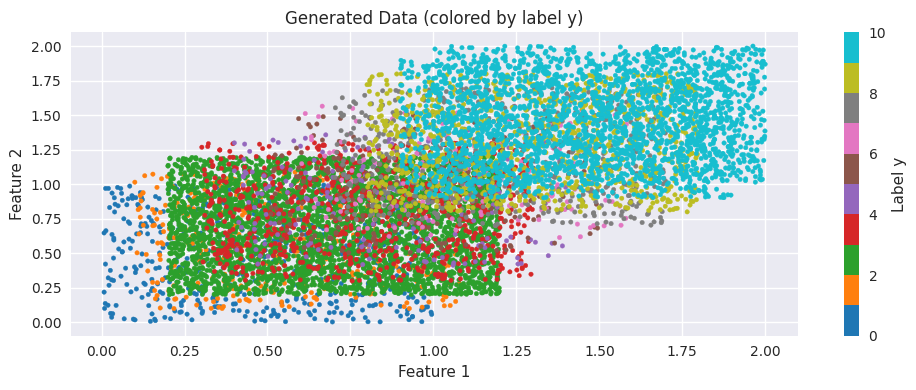

  Data: 10000 samples, 5 features
  True drifts at: [np.int64(566), np.int64(960), np.int64(4526), np.int64(5291), np.int64(5490), np.int64(5678), np.int64(5834), np.int64(6365), np.int64(7370), np.int64(8422)]
  Evaluating D3...
  Evaluating DAWIDD...
  Evaluating ShapeDD...
  Evaluating ADWIN...
  Evaluating DDM...
  Evaluating EDDM...
  Evaluating HDDM_A...
  Evaluating HDDM_W...
  Evaluating FHDDM...
Completed scenario: Common_Drift
Results collected: 9
------------------------------


In [28]:
def run_unified_experiment(scenario_config):
    """Run unified experiment comparing all methods on same data."""
    scenario_name = scenario_config['name']
    params = scenario_config['params']
    
    print(f"Running scenario: {scenario_name}")
    
    try:
        # Generate data
        X, y = gen_random(**params)
        # Plot the generated X and label y
        import matplotlib.pyplot as plt

        plt.figure(figsize=(10, 4))
        if X.shape[1] == 1:
            plt.scatter(range(len(X)), X[:, 0], c=y, cmap='tab10', s=10)
            plt.xlabel('Sample Index')
            plt.ylabel('Feature Value')
        elif X.shape[1] == 2:
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        else:
            # For higher dimensions, plot first two features colored by y
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=10)
            plt.xlabel('Feature 1')
            plt.ylabel('Feature 2')
        plt.title('Generated Data (colored by label y)')
        plt.colorbar(label='Label y')
        plt.tight_layout()
        plt.show()
        true_drifts = np.where(np.diff(y) != 0)[0] + 1
        
        print(f"  Data: {X.shape[0]} samples, {X.shape[1]} features")
        print(f"  True drifts at: {list(true_drifts)}")
        
        results = []
        
        # Evaluate window-based methods
        for method_name in window_methods:
            try:
                print(f"  Evaluating {method_name}...")
                result = evaluate_window_based_method(X, y, true_drifts, method_name)
                result['scenario'] = scenario_name
                results.append(result)
            except Exception as e:
                print(f"    Error in {method_name}: {e}")
                continue
        
        # Evaluate streaming methods  
        for method_name in streaming_methods:
            try:
                print(f"  Evaluating {method_name}...")
                result = evaluate_streaming_method(X, y, true_drifts, method_name)
                result['scenario'] = scenario_name
                results.append(result)
            except Exception as e:
                print(f"    Error in {method_name}: {e}")
                continue
        
        # Force garbage collection
        gc.collect()
        
        return results
        
    except Exception as e:
        print(f"Error in scenario {scenario_name}: {e}")
        return []

# Execute unified benchmark
print("Starting Unified Benchmark Execution")
print("=" * 50)

all_unified_results = []

for scenario in unified_scenarios:
    scenario_results = run_unified_experiment(scenario)
    all_unified_results.extend(scenario_results)
    
    print(f"Completed scenario: {scenario['name']}")
    print(f"Results collected: {len(scenario_results)}")
    print("-" * 30)

# Convert to DataFrame
unified_df = pd.DataFrame(all_unified_results)


In [29]:
# Unified Results Analysis

if len(unified_df) > 0:
    print("Unified Benchmark Results Analysis")
    print("=" * 60)
    
    # Summary statistics
    print(f"Total experiments: {len(unified_df)}")
    print(f"Methods evaluated: {unified_df['method'].nunique()}")
    print(f"Scenarios tested: {unified_df['scenario'].nunique()}")
    print(f"Paradigms: {', '.join(unified_df['paradigm'].unique())}")
    print()
    
    # Performance summary by method
    performance_summary = unified_df.groupby(['method', 'paradigm']).agg({
        'avg_prequential_accuracy': ['mean', 'std'],
        'mttd': ['mean', 'std'],
        'tp': 'sum',
        'fp': 'sum', 
        'fn': 'sum',
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std'],
        'runtime_per_instance_ms': ['mean', 'std'],
        'memory_mb': ['mean', 'std']
    }).round(4)
    
    print("PERFORMANCE SUMMARY BY METHOD:")
    print(performance_summary)
    print()
    
    # Best performers analysis
    print("BEST PERFORMERS:")
    print("-" * 30)
    
    # Best prequential accuracy
    best_accuracy = unified_df.loc[unified_df['avg_prequential_accuracy'].idxmax()]
    print(f"Best Prequential Accuracy: {best_accuracy['method']} ({best_accuracy['avg_prequential_accuracy']:.4f})")
    
    # Best MTTD (lowest)
    valid_mttd = unified_df[unified_df['mttd'] != float('inf')]
    if len(valid_mttd) > 0:
        best_mttd = valid_mttd.loc[valid_mttd['mttd'].idxmin()]
        print(f"Best MTTD: {best_mttd['method']} ({best_mttd['mttd']:.2f} instances)")
    
    # Fastest runtime
    fastest = unified_df.loc[unified_df['runtime_per_instance_ms'].idxmin()]
    print(f"Fastest Runtime: {fastest['method']} ({fastest['runtime_per_instance_ms']:.4f} ms/instance)")
    
    # Lowest memory
    lowest_memory = unified_df.loc[unified_df['memory_mb'].idxmin()]
    print(f"Lowest Memory: {lowest_memory['method']} ({lowest_memory['memory_mb']:.2f} MB)")
    
    print()
    
    # Paradigm comparison
    paradigm_comparison = unified_df.groupby('paradigm').agg({
        'avg_prequential_accuracy': 'mean',
        'mttd': lambda x: np.mean(x[x != float('inf')]) if any(x != float('inf')) else float('inf'),
        'runtime_per_instance_ms': 'mean',
        'memory_mb': 'mean',
        'precision': 'mean',
        'recall': 'mean'
    }).round(4)
    
    print("PARADIGM COMPARISON:")
    print(paradigm_comparison)

else:
    print("No unified results to analyze. Check for errors in benchmark execution.")


Unified Benchmark Results Analysis
Total experiments: 9
Methods evaluated: 9
Scenarios tested: 1
Paradigms: window, streaming

PERFORMANCE SUMMARY BY METHOD:
                  avg_prequential_accuracy      mttd      tp  fp  fn  \
                                      mean std  mean std sum sum sum   
method  paradigm                                                       
ADWIN   streaming                   0.1004 NaN   inf NaN   0   6  10   
D3      window                      1.0000 NaN   inf NaN   0   0  10   
DAWIDD  window                      1.0000 NaN   inf NaN   0   1  10   
DDM     streaming                   0.0998 NaN   3.0 NaN   2   0   8   
EDDM    streaming                   0.1004 NaN  24.0 NaN   1   0   9   
FHDDM   streaming                   0.1004 NaN   inf NaN   0   0  10   
HDDM_A  streaming                   0.0994 NaN   3.5 NaN   2   0   8   
HDDM_W  streaming                   0.0998 NaN   6.5 NaN   2   0   8   
ShapeDD window                      0.9343 NaN   8

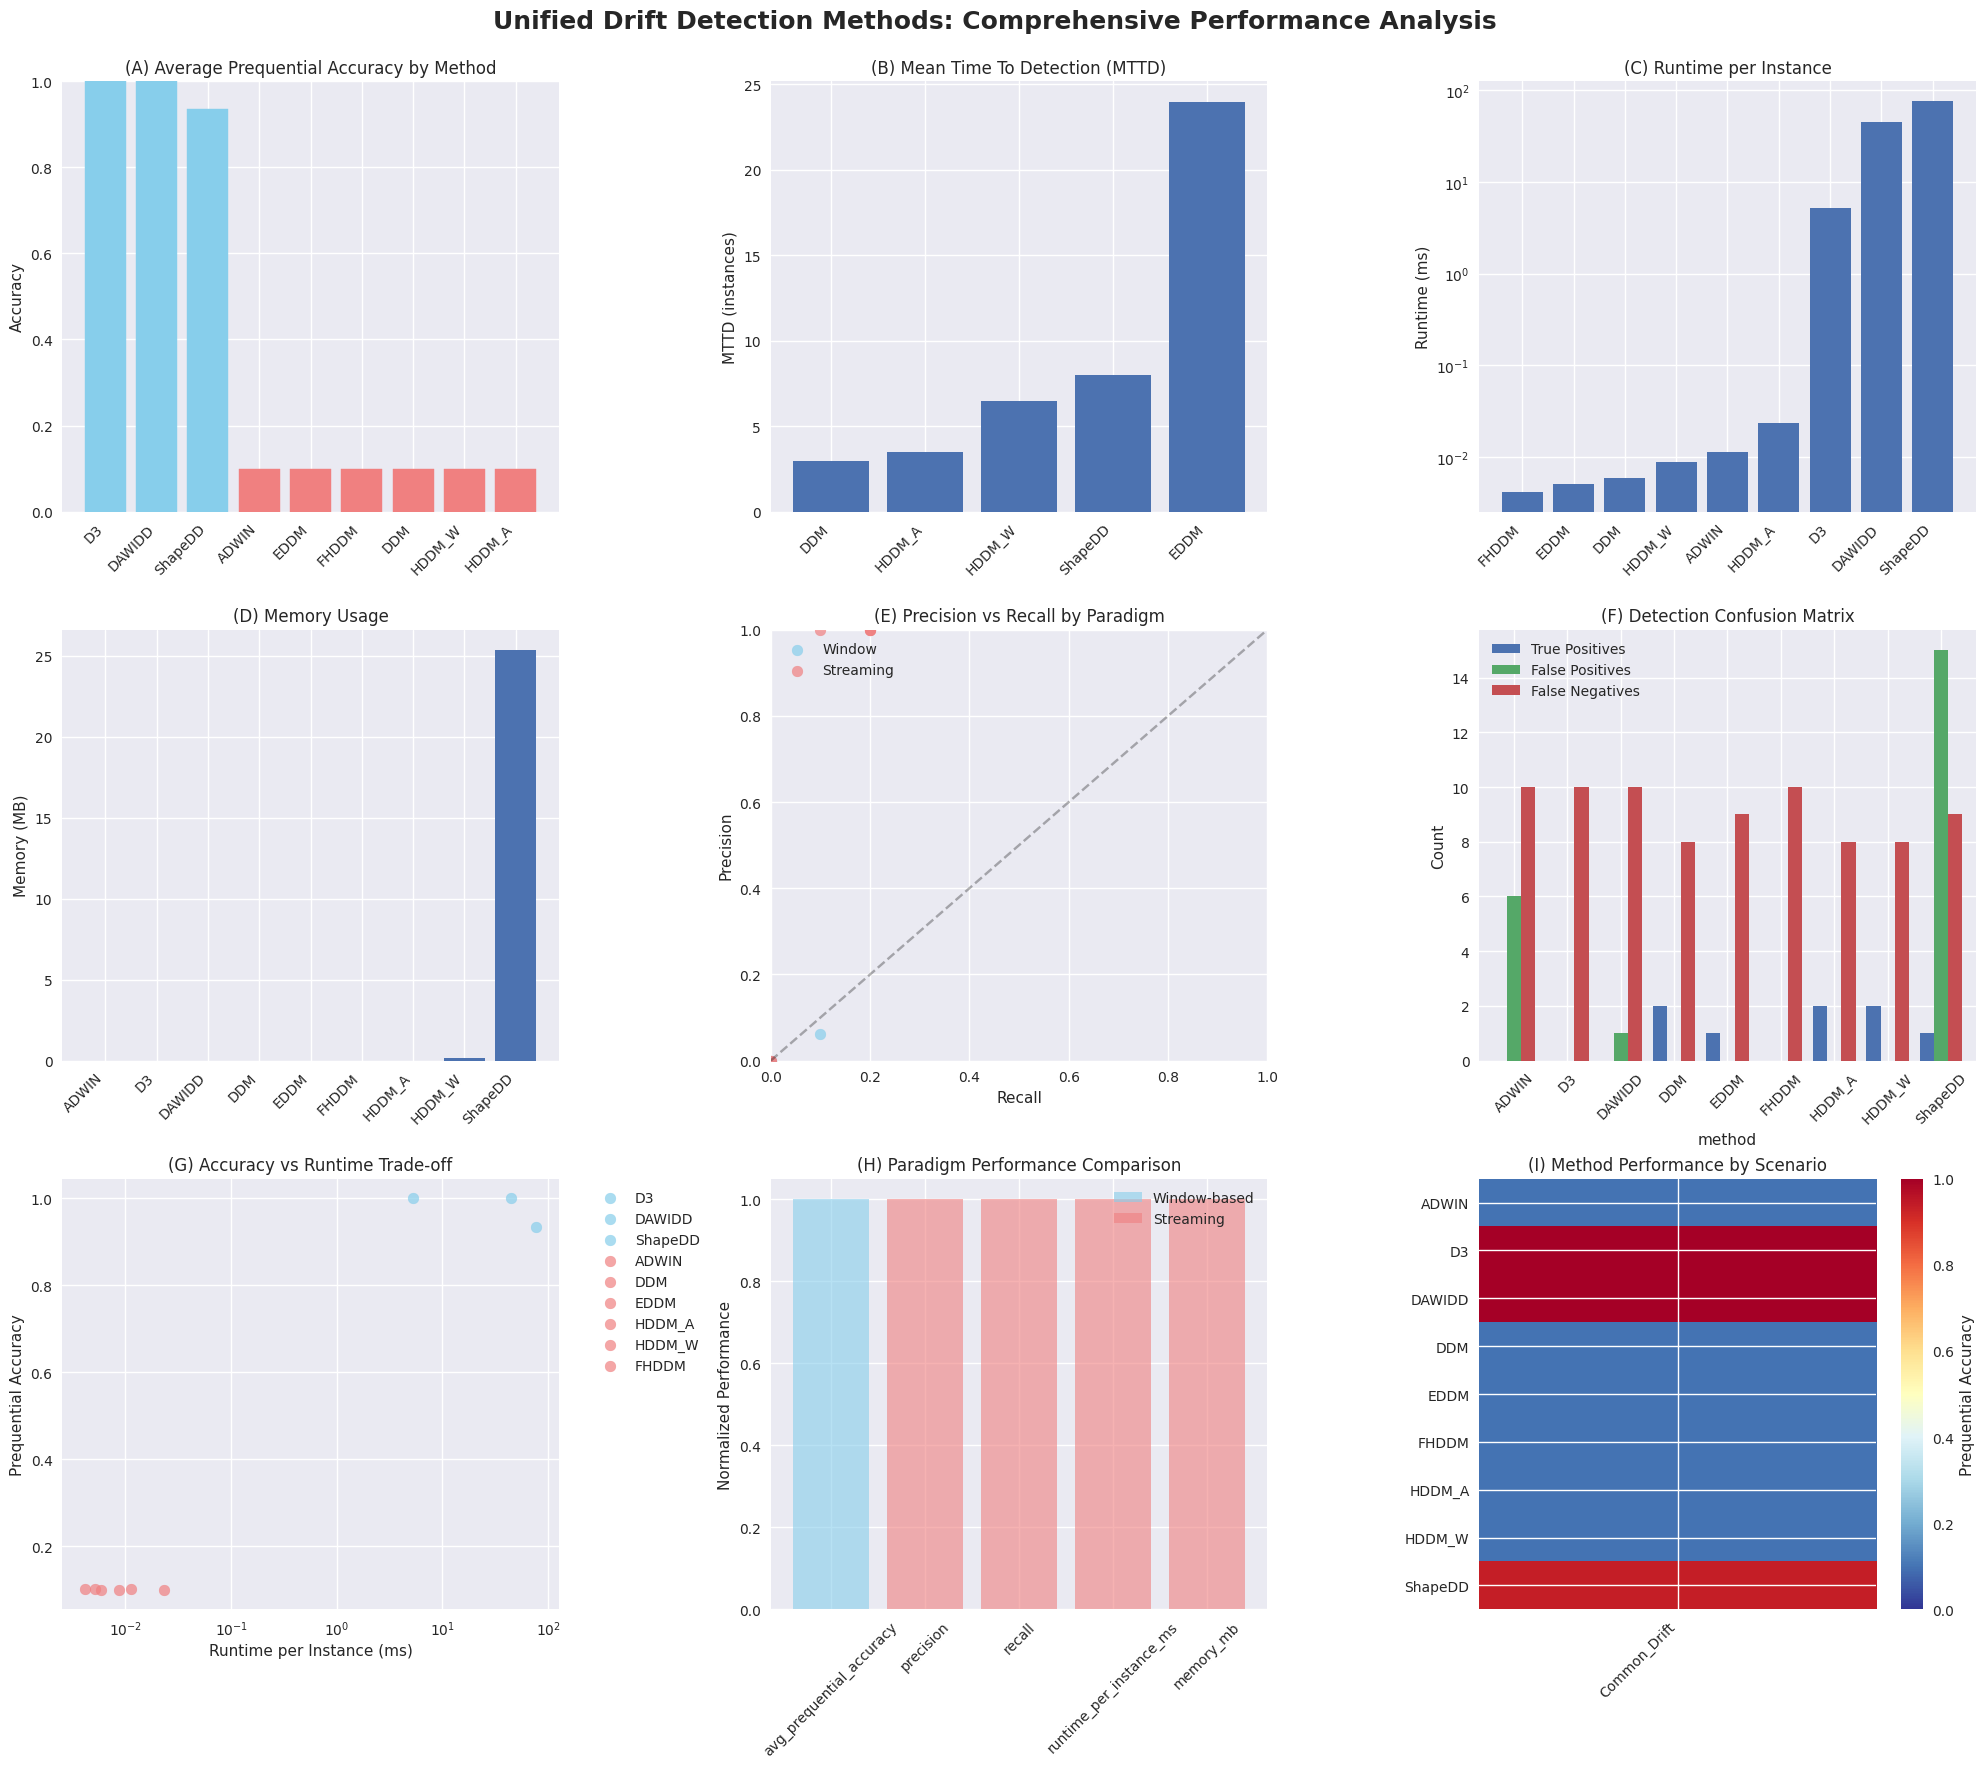

In [30]:
# Unified Performance Visualization

if len(unified_df) > 0:
    # Create comprehensive unified visualization
    fig, axes = plt.subplots(3, 3, figsize=(20, 18))
    
    # 1. Prequential Accuracy by Method
    method_accuracy = unified_df.groupby('method')['avg_prequential_accuracy'].mean().sort_values(ascending=False)
    bars1 = axes[0, 0].bar(range(len(method_accuracy)), method_accuracy.values)
    axes[0, 0].set_xticks(range(len(method_accuracy)))
    axes[0, 0].set_xticklabels(method_accuracy.index, rotation=45, ha='right')
    axes[0, 0].set_title('(A) Average Prequential Accuracy by Method')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_ylim(0, 1)
    
    # Color bars by paradigm
    colors = ['skyblue' if method in window_methods else 'lightcoral' for method in method_accuracy.index]
    for bar, color in zip(bars1, colors):
        bar.set_color(color)
    
    # 2. MTTD Comparison (exclude infinite values)
    valid_mttd = unified_df[unified_df['mttd'] != float('inf')]
    if len(valid_mttd) > 0:
        mttd_by_method = valid_mttd.groupby('method')['mttd'].mean().sort_values()
        axes[0, 1].bar(range(len(mttd_by_method)), mttd_by_method.values)
        axes[0, 1].set_xticks(range(len(mttd_by_method)))
        axes[0, 1].set_xticklabels(mttd_by_method.index, rotation=45, ha='right')
        axes[0, 1].set_title('(B) Mean Time To Detection (MTTD)')
        axes[0, 1].set_ylabel('MTTD (instances)')
    
    # 3. Runtime Performance
    runtime_by_method = unified_df.groupby('method')['runtime_per_instance_ms'].mean().sort_values()
    axes[0, 2].bar(range(len(runtime_by_method)), runtime_by_method.values)
    axes[0, 2].set_xticks(range(len(runtime_by_method)))
    axes[0, 2].set_xticklabels(runtime_by_method.index, rotation=45, ha='right')
    axes[0, 2].set_title('(C) Runtime per Instance')
    axes[0, 2].set_ylabel('Runtime (ms)')
    axes[0, 2].set_yscale('log')
    
    # 4. Memory Usage
    memory_by_method = unified_df.groupby('method')['memory_mb'].mean().sort_values()
    axes[1, 0].bar(range(len(memory_by_method)), memory_by_method.values)
    axes[1, 0].set_xticks(range(len(memory_by_method)))
    axes[1, 0].set_xticklabels(memory_by_method.index, rotation=45, ha='right')
    axes[1, 0].set_title('(D) Memory Usage')
    axes[1, 0].set_ylabel('Memory (MB)')
    
    # 5. Precision vs Recall Scatter
    for paradigm, color in zip(['window', 'streaming'], ['skyblue', 'lightcoral']):
        paradigm_data = unified_df[unified_df['paradigm'] == paradigm]
        axes[1, 1].scatter(paradigm_data['recall'], paradigm_data['precision'], 
                          c=color, label=paradigm.title(), alpha=0.7, s=60)
    
    axes[1, 1].set_xlabel('Recall')
    axes[1, 1].set_ylabel('Precision') 
    axes[1, 1].set_title('(E) Precision vs Recall by Paradigm')
    axes[1, 1].legend()
    axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    
    # 6. TP/FP/FN Analysis
    detection_metrics = unified_df.groupby('method')[['tp', 'fp', 'fn']].sum()
    detection_metrics.plot(kind='bar', ax=axes[1, 2], width=0.8)
    axes[1, 2].set_title('(F) Detection Confusion Matrix')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].legend(['True Positives', 'False Positives', 'False Negatives'])
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    # 7. Accuracy vs Runtime Trade-off
    for method in unified_df['method'].unique():
        method_data = unified_df[unified_df['method'] == method]
        color = 'skyblue' if method in window_methods else 'lightcoral'
        axes[2, 0].scatter(method_data['runtime_per_instance_ms'], 
                          method_data['avg_prequential_accuracy'],
                          label=method, alpha=0.7, s=60, c=color)
    
    axes[2, 0].set_xlabel('Runtime per Instance (ms)')
    axes[2, 0].set_ylabel('Prequential Accuracy')
    axes[2, 0].set_title('(G) Accuracy vs Runtime Trade-off')
    axes[2, 0].set_xscale('log')
    axes[2, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 8. Paradigm Performance Radar
    paradigm_summary = unified_df.groupby('paradigm').agg({
        'avg_prequential_accuracy': 'mean',
        'precision': 'mean', 
        'recall': 'mean',
        'runtime_per_instance_ms': lambda x: 1 / (np.mean(x) + 1e-6),  # Inverse for "better is higher"
        'memory_mb': lambda x: 1 / (np.mean(x) + 1e-6)  # Inverse for "better is higher"
    })
    
    # Normalize to 0-1 scale
    paradigm_normalized = (paradigm_summary - paradigm_summary.min()) / (paradigm_summary.max() - paradigm_summary.min())
    
    axes[2, 1].bar(paradigm_normalized.columns, paradigm_normalized.loc['window'], 
                   alpha=0.6, label='Window-based', color='skyblue')
    axes[2, 1].bar(paradigm_normalized.columns, paradigm_normalized.loc['streaming'], 
                   alpha=0.6, label='Streaming', color='lightcoral')
    axes[2, 1].set_title('(H) Paradigm Performance Comparison')
    axes[2, 1].set_ylabel('Normalized Performance')
    axes[2, 1].legend()
    axes[2, 1].tick_params(axis='x', rotation=45)
    
    # 9. Scenario Performance Heatmap
    scenario_perf = unified_df.pivot_table(values='avg_prequential_accuracy', 
                                          index='method', 
                                          columns='scenario', 
                                          aggfunc='mean')
    im = axes[2, 2].imshow(scenario_perf.values, cmap='RdYlBu_r', aspect='auto', vmin=0, vmax=1)
    axes[2, 2].set_xticks(range(len(scenario_perf.columns)))
    axes[2, 2].set_xticklabels(scenario_perf.columns, rotation=45, ha='right')
    axes[2, 2].set_yticks(range(len(scenario_perf.index)))
    axes[2, 2].set_yticklabels(scenario_perf.index)
    axes[2, 2].set_title('(I) Method Performance by Scenario')
    plt.colorbar(im, ax=axes[2, 2], label='Prequential Accuracy')
    
    plt.tight_layout()
    plt.suptitle('Unified Drift Detection Methods: Comprehensive Performance Analysis', 
                 fontsize=18, fontweight='bold', y=0.98)
    plt.subplots_adjust(top=0.94)
    plt.show()

else:
    print("No unified results available for visualization.")
